In [1]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [2]:
tqdm.pandas()


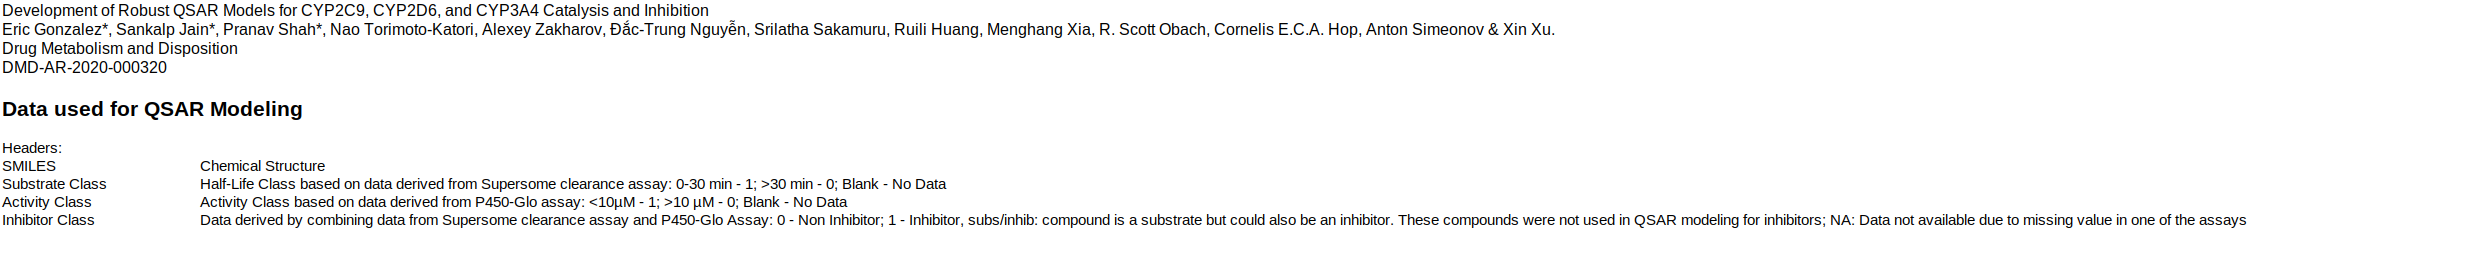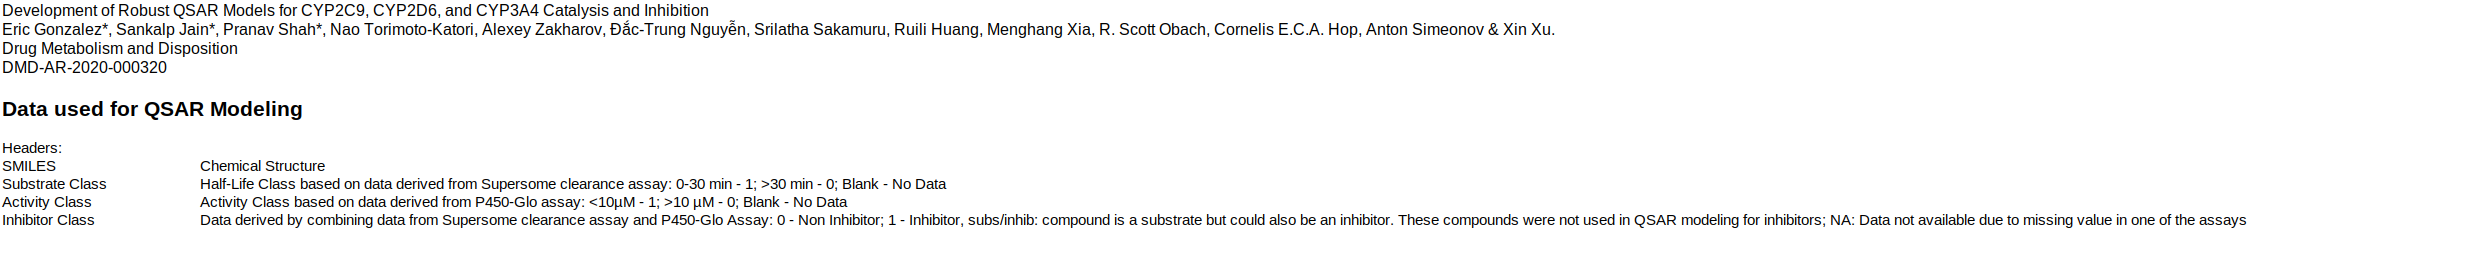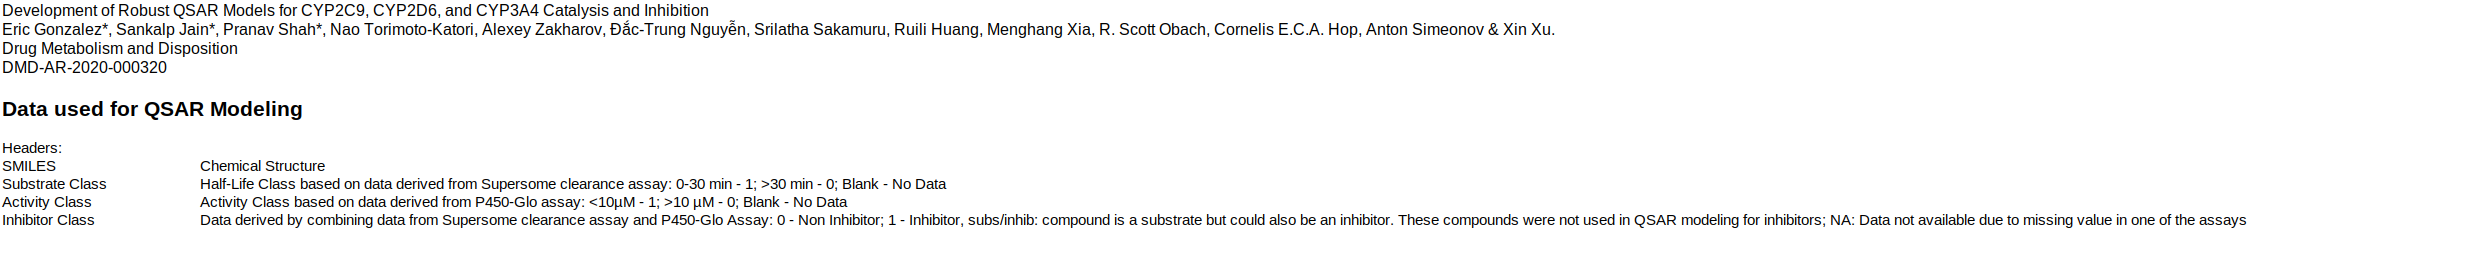

In [3]:
df = pd.read_csv("./XinXu_NCATS_ADME_raw/DMD320R2_Supp2.csv")
df

,SMILES,CYP2C9 Substrate Class,CYP2D6 Substrate Class,CYP3A4 Substrate Class,CYP2C9 Activity Class,CYP2D6 Activity Class,CYP3A4 Activity Class,CYP2C9 Inhibitor Class,CYP2D6 Inhibitor Class,CYP3A4_ Inhibitor Class
0,CC(C)(C)C1=C(O)C=CC(O)=C1,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1
1,OC(=O)C\C(=C/C(O)=O)C(O)=O,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0,NaN
2,CC(C)=CCC\C(C)=C\CO,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0
3,CC1=CC(N)=C2C=C(NC(=O)NC3=CC4=C(C=C3)N=C(C)C=C...,0.0,0.0,NaN,0.0,1.0,0.0,0,1,NaN
4,CC1=C(O)C(CN)=C(CO)C=N1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4297,CCOC(=O)CSC1=NC2=C(SC3=C2C=CC=C3)C(=O)N1CCCN4C...,0.0,1.0,1.0,0.0,1.0,1.0,0,subs/inhib,subs/inhib
4298,CCC1=CC=C(C=C1)C2=NC(CSCC(=O)NCCC3=CC=CC=C3)=C...,1.0,NaN,1.0,1.0,0.0,1.0,subs/inhib,NaN,subs/inhib
4299,CC(C)[C@H](N1CCC(CC1)C(O)=O)C2=C(CN(CC3=CC(=CC...,0.0,0.0,1.0,0.0,0.0,1.0,0,0,subs/inhib
4300,COCCOC1=NC2=C(NC(=O)N2CC3=CC=C(C=C3)C(O)=O)C(N...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0,NaN


In [4]:
df.columns

Index(['SMILES', 'CYP2C9 Substrate Class', 'CYP2D6 Substrate Class',
       'CYP3A4 Substrate Class', 'CYP2C9 Activity Class',
       'CYP2D6 Activity Class', 'CYP3A4 Activity Class',
       'CYP2C9 Inhibitor Class', 'CYP2D6 Inhibitor Class',
       'CYP3A4_ Inhibitor Class'],
      dtype='object')

In [5]:
df["CYP2D6 Activity Class"].value_counts()

CYP2D6 Activity Class
0.0    3101
1.0    1034
Name: count, dtype: int64

In [6]:
df["CYP2D6 Activity Class"].value_counts()

CYP2D6 Activity Class
0.0    3101
1.0    1034
Name: count, dtype: int64

In [7]:
df["CYP2D6 Substrate Class"].value_counts()

CYP2D6 Substrate Class
0.0    2628
1.0    1318
Name: count, dtype: int64

In [8]:
mask = df["CYP2D6 Substrate Class"] == 1.0

In [9]:
# standardisation of SMILES
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
import mols2grid

In [10]:

# from Pat Walters method
def standardize_smiles(smiles):
    try:
        # follows the steps in
        # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
        # as described **excellently** (by Greg) in
        # https://www.youtube.com/watch?v=eWTApNX8dJQ
        mol = Chem.MolFromSmiles(smiles)
    
        # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
        clean_mol = rdMolStandardize.Cleanup(mol)
    
        # if many fragments, get the "parent" (the actual mol we are interested in) 
        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    
        # try to neutralize molecule
        uncharger = rdMolStandardize.Uncharger()  # annoying, but necessary as no convenience method exists
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    
        # note that no attempt is made at reionization at this step
        # nor at ionization at some pH (rdkit has no pKa caculator)
        # the main aim to represent all molecules from different sources
        # in a (single) standard way, for use in ML, catalogue, etc.
    
        te = rdMolStandardize.TautomerEnumerator()  # idem
        taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    
        return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)
    except:
        return pd.NA

In [11]:

with BlockLogs():
    df["CANONICAL_SMILES"] = df["SMILES"].progress_apply(lambda x: standardize_smiles(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4302/4302 [00:33<00:00, 127.89it/s]


In [12]:
def smi_to_inchikey(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToInchiKey(mol)
    except:
        return pd.NA

In [13]:
# compute inchikeys
with BlockLogs():
    df["INCHIKEY"] = df["CANONICAL_SMILES"].progress_apply(lambda x: smi_to_inchikey(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4302/4302 [00:01<00:00, 3735.24it/s]


In [16]:
# not much more to do really
df["dataset"] = "XinXu_NCATS_ADME_raw"
df["data_type"] = "assay" # going to assume assay
df["action_type"] = "substrate"
df["active"] = mask
df["common_name"] = pd.NA

In [17]:
df.to_csv("processed/xin_xu_ncats_adme.csv", index=False)